<a href="https://colab.research.google.com/github/Fenysepthalia/Project-Tugas-4/blob/main/Modul_4_Penyy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Soal Praktikum Overfitting Handling #2**

## Kegiatan 1 **(Individu)** 
70 poin

**Peraturan :**
* Tidak boleh ada error dalam kode program
* Dalam modul ini tidak diperbolehkan menggunakan teknik transfer learning dari pretrain model baik yang di bangun sendiri atau anda dapatkan dari sumber lain (tensorflow, keras, dan sebagainya)
* Perhatikan langkah demi langkah yang diperintahkan dalam kegiatan ini

### **SOAL 1 :** 
---
Dalam mendefinisikan model Machine Learing ada banyak cara untuk mendapatkan model dengan performa terbaik salah satunya adalah hyperparameter tuning. Contoh hyperparameter tuning telah diberikan dalam materi di modul ini, dalam kegiatan ini telah diberikan sedikit contoh lain untuk mendefinisikan model hyperparameter tuning dengan hparam. **Tugas anda dalam kegiatan modul kali ini adalah membuat model CNN dengan hyperparameter tuning dengan ketentuan wajib sebagai berikut :**
* Menerapkan materi dari modul-modul sebelumnya (modul 2 dan 3)
* **Menggunakan image disease dataset (bebas dari sumber mana saja)**
* Menggunakan dataset dengan jumlah minimal 5000 data
* Lakukan eksperimen model untuk mencari model CNN dengan performa terbaik untuk mengklasifikasikan dataset yang anda gunakan.
* Definisikan minimal 2 model CNN dengan komposisi parameter yang berbeda-beda.
* Masing-masing model memiliki **minimal** 50 epoch.
* Dalam mendefinisikan model, WAJIB melakukan tuning minimal pada 3 parameter model yang dirubah misalnya merubah jumlah neuron, nilai dropout, nilai lerning rate, jenis optimizer, jenis activation function dsb.
* Visualisasikan hasil evaluasi performa model. Anda dapat menggunakan plot pada umumnya seperti grafik loss dan accuracy dengan matplotib atau visualisasi interaktif menggunakan tensorboard seperti pada contoh dibawah.



In [2]:
# Tulis Program Anda Disini!

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Disease"

In [4]:
%cd /content/drive/My Drive/Disease

/content/drive/My Drive/Disease


In [5]:
ls

kaggle.json


In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 35.1MB/s]
100% 2.29G/2.29G [00:27<00:00, 90.6MB/s]


In [7]:
!unzip \*.zip &> /dev/null && rm *.zip

In [8]:
ls

chest_xray/  kaggle.json


In [9]:
from os import mkdir

mkdir ('Data')

In [10]:
import shutil,sys

shutil.move("/content/drive/My Drive/Disease/chest_xray/train/NORMAL", "/content/drive/My Drive/Disease/Data")
shutil.move("/content/drive/My Drive/Disease/chest_xray/train/PNEUMONIA", "/content/drive/My Drive/Disease/Data")

'/content/drive/My Drive/Disease/Data/PNEUMONIA'

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import random

In [ ]:
%rm -rf Test/
%rm -rf Train/
%rm -rf Valid/

In [12]:
TRAIN_DIR = "/content/drive/My Drive/Disease/Train/"
VALID_DIR ="/content/drive/My Drive/Disease/Valid/"
TEST_DIR ="/content/drive/My Drive/Disease/Test/"

os.mkdir(TRAIN_DIR)
os.mkdir(VALID_DIR)
os.mkdir(TEST_DIR)

for label in ['NORMAL', 'PNEUMONIA']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(VALID_DIR+label)
    os.mkdir(TEST_DIR+label)

In [13]:
def train_valid_test_split(source, train_dir, valid_dir, test_dir,train_size, valid_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-(valid_size + train_size)))
    valid_size = int(len(files) * (1-(valid_size + test_size)))
    test_size = int(len(files) * (1-train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:valid_size]
    valid_set = shuffled_files[valid_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)
        
    for filename in valid_set:
        filepath = source + filename
        destination = valid_dir + filename
        copyfile(filepath, destination)
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/drive/My Drive/Disease/Data/"

for label in ['NORMAL', 'PNEUMONIA']:
    print(label)
    train_valid_test_split(SOURCE+label+'/',  TRAIN_DIR +label+'/', VALID_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, valid_size=0.19, test_size=0.01)
    print('Total images: ', len(os.listdir(SOURCE +label+'/')))
    print('Training: ', len(os.listdir(TRAIN_DIR +label+'/')))
    print('Validation: ', len(os.listdir(VALID_DIR +label+'/')))
    print('Testing: ', len(os.listdir(TEST_DIR +label+'/')))
    print()

NORMAL
Total images:  1341
Training:  1059
Validation:  269
Testing:  13

PNEUMONIA
Total images:  3875
Training:  3062
Validation:  775
Testing:  38



In [27]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    fill_mode='nearest'
)

training_set = train_datagen.flow_from_directory("/content/drive/My Drive/Disease/Train/", 
                                                 target_size=(100,100),
                                                 color_mode="rgb",
                                                 shuffle=False,
                                                 batch_size = 8,
                                                 class_mode='categorical')

Found 4121 images belonging to 2 classes.


In [28]:
from keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    fill_mode='nearest'
)

val_set = val_datagen.flow_from_directory("/content/drive/My Drive/Disease/Valid/", 
                                                 target_size=(100,100),
                                                 color_mode="rgb",
                                                 shuffle=False,
                                                 batch_size = 8,
                                                 class_mode='categorical')

Found 1044 images belonging to 2 classes.


In [29]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2,
    fill_mode='nearest'
)

test_set = test_datagen.flow_from_directory("/content/drive/My Drive/Disease/Test/", 
                                                 target_size=(100,100),
                                                 color_mode="rgb",
                                                 shuffle=False,
                                                 batch_size = 8,
                                                 class_mode='categorical')

Found 51 images belonging to 2 classes.


In [30]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [31]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
!rm -rf ./logs/ 

In [33]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'adadelta']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [36]:
xvl, yvl = zip(*(val_set[i] for i in range(len(val_set))))
x_val, y_val = np.vstack(xvl), np.vstack(yvl)

In [42]:
def train_test_model(hparams):
  model = Sequential()
  model.add(Conv2D(filters = 32, kernel_size=(3, 3), input_shape = (100, 100, 3))),
  model.add(BatchNormalization()),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(Dropout(hparams[HP_DROPOUT])),
  model.add(Conv2D(filters = 32, kernel_size=(3, 3), input_shape = (100, 100, 3), activation = 'relu')),
  model.add(BatchNormalization()),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(Dropout(hparams[HP_DROPOUT])),
  model.add(Conv2D(filters = 32, kernel_size=(3, 3), input_shape = (100, 100, 3), activation = 'relu')),
  model.add(BatchNormalization()),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(MaxPooling2D(pool_size=(2,2))),
  model.add(Dropout(hparams[HP_DROPOUT])),
  model.add(Flatten()),
  model.add(Dense(hparams[HP_NUM_UNITS], activation = 'relu')),
  model.add(Dense(64, activation='relu')),
  model.add(Dense(32, activation='relu')),
  model.add(Dropout(hparams[HP_DROPOUT])),
  model.add(Dense(2, activation='softmax'))

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(training_set, 
            validation_data=val_set, 
            epochs=50,
            callbacks=ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.001),
  )
  _, accuracy = model.evaluate(x_val, y_val)
  return accuracy

In [43]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=50)

In [ ]:
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization, AveragePooling2D
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'adadelta'}
Epoch 1/50
516/516 [==============================] - 81s 155ms/step - loss: 0.7996 - accuracy: 0.5955 - val_loss: 0.5727 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 2/50
516/516 [==============================] - 80s 156ms/step - loss: 0.7816 - accuracy: 0.6103 - val_loss: 0.5622 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 3/50
516/516 [==============================] - 80s 155ms/step - loss: 0.7617 - accuracy: 0.6287 - val_loss: 0.5660 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 4/50
516/516 [==============================] - 79s 154ms/step - loss: 0.7540 - accuracy: 0.6413 - val_loss: 0.5493 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 5/50
516/516 [==============================] - 80s 155ms/step - loss: 0.7544 - accuracy: 0.6331 - val_loss: 0.5594 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 6/50
516/516 [==============================] - 80s 154ms/step - loss: 0.7527 - accuracy: 0.6523 - val_loss: 0.5510 - 

**MODELLING**

In [ ]:
# Model 1
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 50 , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/50
129/129 [==============================] - 27s 122ms/step - loss: 0.4493 - accuracy: 0.8265 - val_loss: 7.6721 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - 15s 113ms/step - loss: 0.2327 - accuracy: 0.8959 - val_loss: 6.3947 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9146
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
129/129 [==============================] - 15s 113ms/step - loss: 0.2159 - accuracy: 0.9146 - val_loss: 6.1465 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/50
129/129 [==============================] - 15s 113ms/step - loss: 0.1856 - accuracy: 0.9321 - val_loss: 3.5506 - val_accuracy: 0.7423 - lr: 3.0000e-04
Epoch 5/50
129/129 [==============================] - 15s 113ms/step - loss: 0.1657 - accuracy: 0.9342 - val_loss: 0.1594 - val_accuracy: 0.9406 - lr: 3.0000e-04
Epoch 6/50
129/129 [=================

In [ ]:
# Model 2
model2 = Sequential()
model2.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model2.add(BatchNormalization())
model2.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model2.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(BatchNormalization())
model2.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model2.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.20))
model2.add(BatchNormalization())
model2.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model2.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(AveragePooling2D((2,2) , strides = 2 , padding = 'same'))

model2.add(Flatten())
model2.add(Dense(units = 145 , activation = 'relu'))
model2.add(Dropout(0.5))

model2.add(Dense(units = 1 , activation = 'sigmoid'))
model2.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d (AverageP  (None, 75, 75, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 64)      

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
History = model2.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 50 , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/50
129/129 [==============================] - 16s 117ms/step - loss: 0.3624 - accuracy: 0.8556 - val_loss: 3.2252 - val_accuracy: 0.2577 - lr: 0.0010
Epoch 2/50
129/129 [==============================] - 15s 113ms/step - loss: 0.2640 - accuracy: 0.8947 - val_loss: 3.9372 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/50
129/129 [==============================] - 14s 109ms/step - loss: 0.2299 - accuracy: 0.9056 - val_loss: 3.2486 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 4/50
129/129 [==============================] - 15s 113ms/step - loss: 0.2173 - accuracy: 0.9117 - val_loss: 2.0971 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 5/50
129/129 [==============================] - 15s 116ms/step - loss: 0.1941 - accuracy: 0.9223 - val_loss: 2.7239 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 6/50
129/129 [==============================] - 14s 111ms/step - loss: 0.1978 - accuracy: 0.9243 - val_loss: 0.2505 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 7/50
129/129 [==============================] 

### **SOAL 2 :**

---
Untuk mendapatkan penilaian pada soal ke 2 ini anda **wajib** mengerjakan soal nomer 1 terlebih dahulu. Tunjukkan kepada asisten bahwa anda telah menyelesaikan seluruh soal wajib diatas dan jelaskan dengan sebaik mungkin kepada asisten.


**Poin penilaian**
* Dapat menunjukkan dan menjelaskan hasil evaluasi masing-masing model yang digunakan.
* Dapat memvisualisasikan hasil evaluasi model dan menjelaskannya kepada asisten. 
* Menggunakan maptplotlib atau seaborn untuk visualisasi loss dan accuracy
* Menampilkan hasil evaluasi berupa nilai presisi, akurasi, recall, f1 score dan confusion matrix.
* Menggunakan tensorboard untuk visualisasi hasil evaluasi model menggunakan hyperparameter tuning.
* Menggunakan Hparam untuk tuning model.
* Hasil accuracy model terbaik >= 80% 
* Hasil loss model terbaik < 5%

**Model 1**

In [ ]:
# Tulis Program Anda Disini!
print ("Loss - ", model.evaluate(x_test, y_test)[0])
print ("Accuracy - ", model.evaluate(x_test, y_test)[1]*100, "%")

2/2 [==============================] - 1s 344ms/step - loss: 0.6879 - accuracy: 0.7451
Loss -  0.68790602684021
2/2 [==============================] - 0s 24ms/step - loss: 0.6879 - accuracy: 0.7451
Accuracy -  74.50980544090271 %


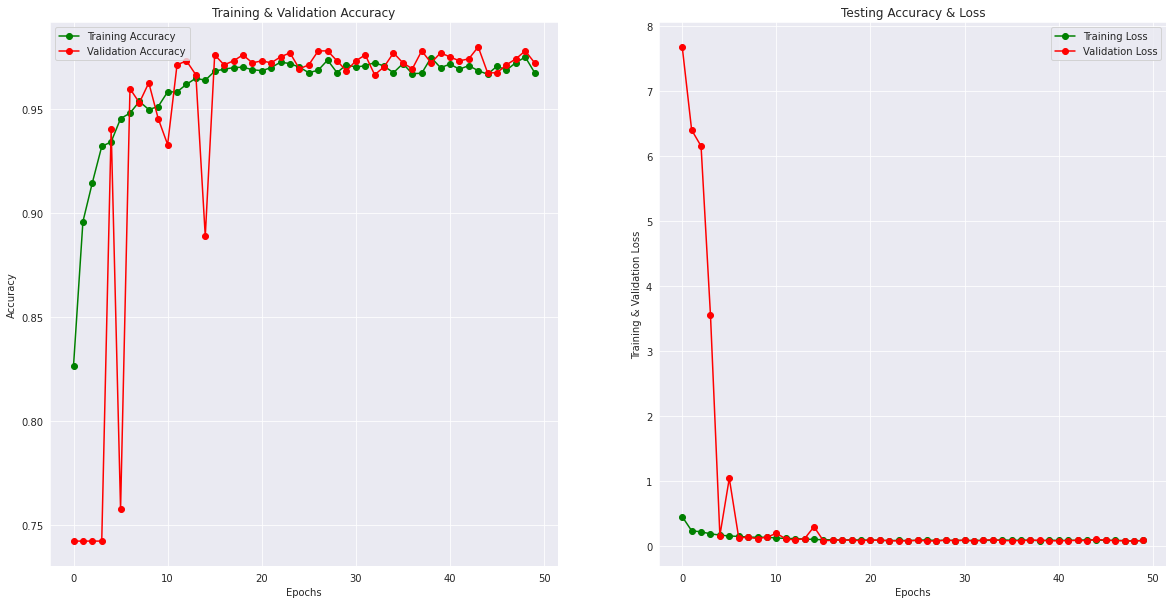

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.75      1.00      0.85        38
   Normal (Class 1)       0.00      0.00      0.00        13

           accuracy                           0.75        51
          macro avg       0.37      0.50      0.43        51
       weighted avg       0.56      0.75      0.64        51



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[38,  0],
       [13,  0]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

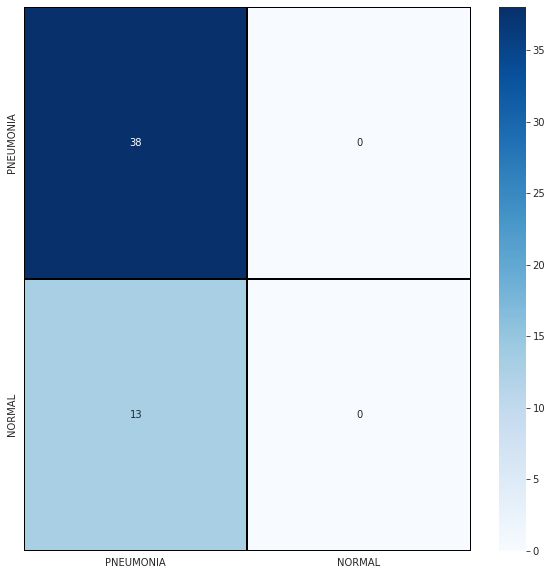

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

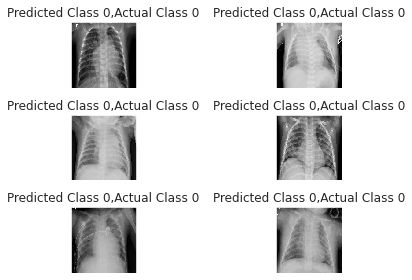

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Model 2**


In [ ]:
print ("Loss - ", model2.evaluate(x_test, y_test)[0])
print ("Accuracy - ", model2.evaluate(x_test, y_test)[1]*100, "%")

2/2 [==============================] - 0s 27ms/step - loss: 0.0815 - accuracy: 0.9608
Loss -  0.0814734697341919
2/2 [==============================] - 0s 26ms/step - loss: 0.0815 - accuracy: 0.9608
Accuracy -  96.07843160629272 %


AttributeError: ignored

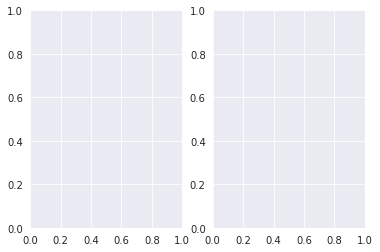

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = History.History['accuracy']
train_loss = History.History['loss']
val_acc = History.History['val_accuracy']
val_loss = History.History['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = (model2.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       1.00      0.95      0.97        38
   Normal (Class 1)       0.87      1.00      0.93        13

           accuracy                           0.96        51
          macro avg       0.93      0.97      0.95        51
       weighted avg       0.97      0.96      0.96        51



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[36,  2],
       [ 0, 13]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

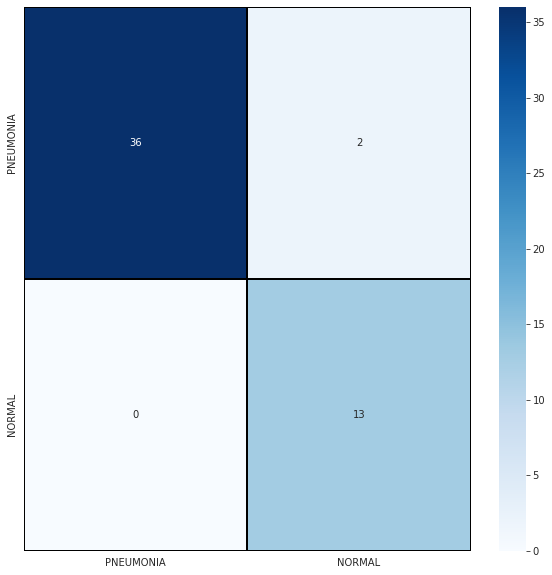

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

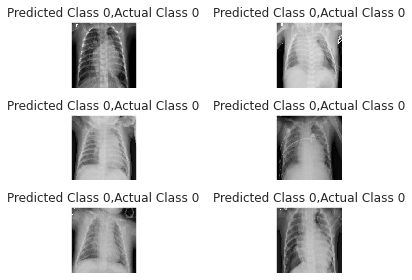

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Kegiatan 2 **(berkelompok)**
30 poin

**Ketentuan Wajib**
* Tulis dokumentasi tugas kelompok anda dalam file README.md
* Cek daftar dataset seluruh praktikan [disini](https://docs.google.com/spreadsheets/d/1qyu5AVDhPhegpRTbNaDoq5qXX4_CX09Q7tYyD-fkF_c/edit?usp=sharing)
* Seluruh data dan progress pengerjaan tugas kelompok harus berada dalam github repository sebelum praktikum dimulai
* Tidak diperbolehkan berganti anggota kelompok selama satu semester ini
* Tidak diperbolehkan berganti repository selama mengerjakan tugas kelompok ini
* **Tidak diperbolehkan berganti dataset atau jurnal rujukan**
* Pastikan anda menggunakan akun github pribadi untuk melakukan commit dan push

**Penilaian**
* Keaktifan dalam tim
* Kontribusi dalam proyek dan tim
* Penerapan prinsip kerja Agile (sprint backlog dan report terdokumentasikan dengan baik)
* Progress pengerjaan tugas kelompok
* Problem solving masing - masing anggota terhadap kendala yang dialami
* Pemahaman masing - masing anggota tim terhadap tugas yang dikerjakan
* Pendokumentasian proyek "clear and clean documentation"

**Materi pendukung**
* [Project documentation](https://realpython.com/documenting-python-code)
* [Github readme](https://docs.github.com/en/github/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
* [Sprint backlog](https://www.lucidchart.com/blog/how-to-develop-a-product-backlog-in-agile)

**Tugas**

Melanjutkan tugas kelompok di modul 1 sampai 3 sekarang kerjakan beberapa poin berikut untuk didemokan kepada asisten masing-masing.

*   Melakukan proses preprocessing dataset dengan ketentuan:
 * augmentasi data menggunakan ImageDataGenerator
 * balancing dataset menggunakan teknik oversampling / downsampling
 * splitting dataset menjadi (75% train, 14% validation, 1% test)
*   Melakukan training beberapa skema model menggunakan model CNN sederhana buatan sendiri **(minimal 2 model)** *tidak diperbolehkan menggunakan transfer learning* 
 * Menerapkan proses Convolution
 * Menerapkan proses Pooling
 * Menerapkan Dropout
 * Menerpakan BatchNormalization
 * Menerapkan learning rate scheduller
 * Menggunakan hyperparameter tuning
 * Minimal 100 epoch per model
* Menyimpan model yang telah di training kedalam file `.json` dan weight kedalam file `.h5` [Lihat disini](https://www.tensorflow.org/guide/keras/save_and_serialize)
*  Mencatat hasil perkembangan tugas kelompok dalam file `sprint_project.xlsx` tandai masing-masing task dengan status **Done** *untuk task yang telah selesai dikerjakan*, **On Going** *untuk task yang dalam proses pengerjaan*, **Waiting** *untuk task yang belum atau akan dikerjakan*
* Pastikan anda menulis tanggal mulai dan tanggal selesai masing-masing task dengan benar
* Pastikan anda menulis penanggung jawab masing-masing task (Penanggung jawab bertugas menyelesaikan dan menuntaskan masing-masing task yang diberikan)
* `commit` dan `push` seluruh perkerjaan yang anda lakukan kedalam branch pribadi dalam repository tugas kelompok yang telah anda buat sebelumnya.
* Presentasikan kepada asisten tentang apa yang anda lakukakan selama mengerjakan tugas kelompok ini. Ceritakan tentang tugas masing-masing anggota,  kendala dalam mengerjakan tugas sampai solusi yang anda lakukan saat mengerjakan tugas kelompok ini.

